In [1]:
import os
import pandas as pd
import shap
import xgboost
import numpy as np
import csv

from xgboost import plot_tree
import matplotlib.pyplot as plt

# Function to calculate the accuracy of the model
def calculate_acc(pred, labels):
    matches = 0
    for i in range(len(labels)):
      if pred[i] == labels[i]:
        matches += 1    
    return matches/len(labels)


def get_all_shap(shap_values, max_display=None, silent=None):
    
    """Get the values from the SHAP summary plot, only for multiclass

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    silent : bool
        Print out the calculations
    """
    
    # Start values
    if max_display is None:
        max_display = 2

    if silent is None:
        silent = True



    # get the id of the most important features  [not important: most important]
    feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0))

    # reverse the array tp [most important, ..., less important]
    feature_order = np.flip(feature_order)

    # get a list with the most important feature names
    feature_names = ['label']
    for i in feature_order[0:max_display]:
        feature_names.append(df.columns[i+1])
        
    # print out the most important features
    if not silent:
        print("Most important features:")
        print(feature_names[1:])

    # get the names of the class
    class_names = model.classes_

    # get only the ids to num_max features
    feature_inds = feature_order[:max_display]

    # get a list with id's of the classes
    class_inds = np.arange(len(class_names))

    # create empty list to store all shap values
    all_shap = []

    # append the feature_names to the list
    all_shap.append(feature_names)


    # i = counter, ind = class_inds 
    for i,ind in enumerate(class_inds):

        # get an array with all the shap-values [shap_value_feature1, shap_value_feature2...]
        global_shap_values = np.abs(shap_values[ind]).mean(0)
        values = global_shap_values[feature_inds]

        # get the class for the array with the shap values
        label=class_names[ind]

        # add the class to the array
        values = np.concatenate((np.array([label]),values) , axis=0)

        # store the values
        all_shap.append(values.tolist())
        
    return all_shap

## Data Preperation
#### Import the data

In [2]:
path_to_data = "/Users/tim/Documents/HTW_Berlin/2_WS_21_22/projektarbeit_XAI/data_02/Frequency Features/frequencyFeatures.csv"

#read in the data using pandas
df = pd.read_csv(path_to_data)

#check data has been read in properly
df.head()

# Delete the two features
df = df.drop(['Label', 'Timestamp'], axis=1)
df


# Delete the label "off"
df = df.iloc[250:, :]
df

# Create x and y partition
x = df.iloc[:,1:]
x.shape
print(x.iloc[[0]])

y = df.iloc[:,0]
y.shape
print(y.iloc[[2]])

from sklearn.model_selection import train_test_split

# Split the data in 80% Train and 20% Test Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# data must be a numpy array
np_y_test = y_test.to_numpy()

      xAcc010Hz   xAcc015Hz   xAcc020Hz   xAcc025Hz   xAcc030Hz    xAcc035Hz  \
250  454.729201  373.662293  841.151061  740.903054  335.169305  1277.359858   

       xAcc040Hz    xAcc045Hz    xAcc050Hz   xAcc055Hz  ...  snd2275Hz  \
250  2338.590535  9415.907494  11120.59792  1928.31614  ...   2.081464   

     snd2300Hz  snd2325Hz  snd2350Hz  snd2375Hz  snd2400Hz  snd2425Hz  \
250   2.573535   2.920927   4.982745   3.420132   0.867515   4.606851   

     snd2450Hz  snd2475Hz  snd2500Hz  
250   2.301164    3.85005    2.09261  

[1 rows x 169 columns]
252    2
Name: ID, dtype: int64


## Create a model

Acc:  0.9685714285714285


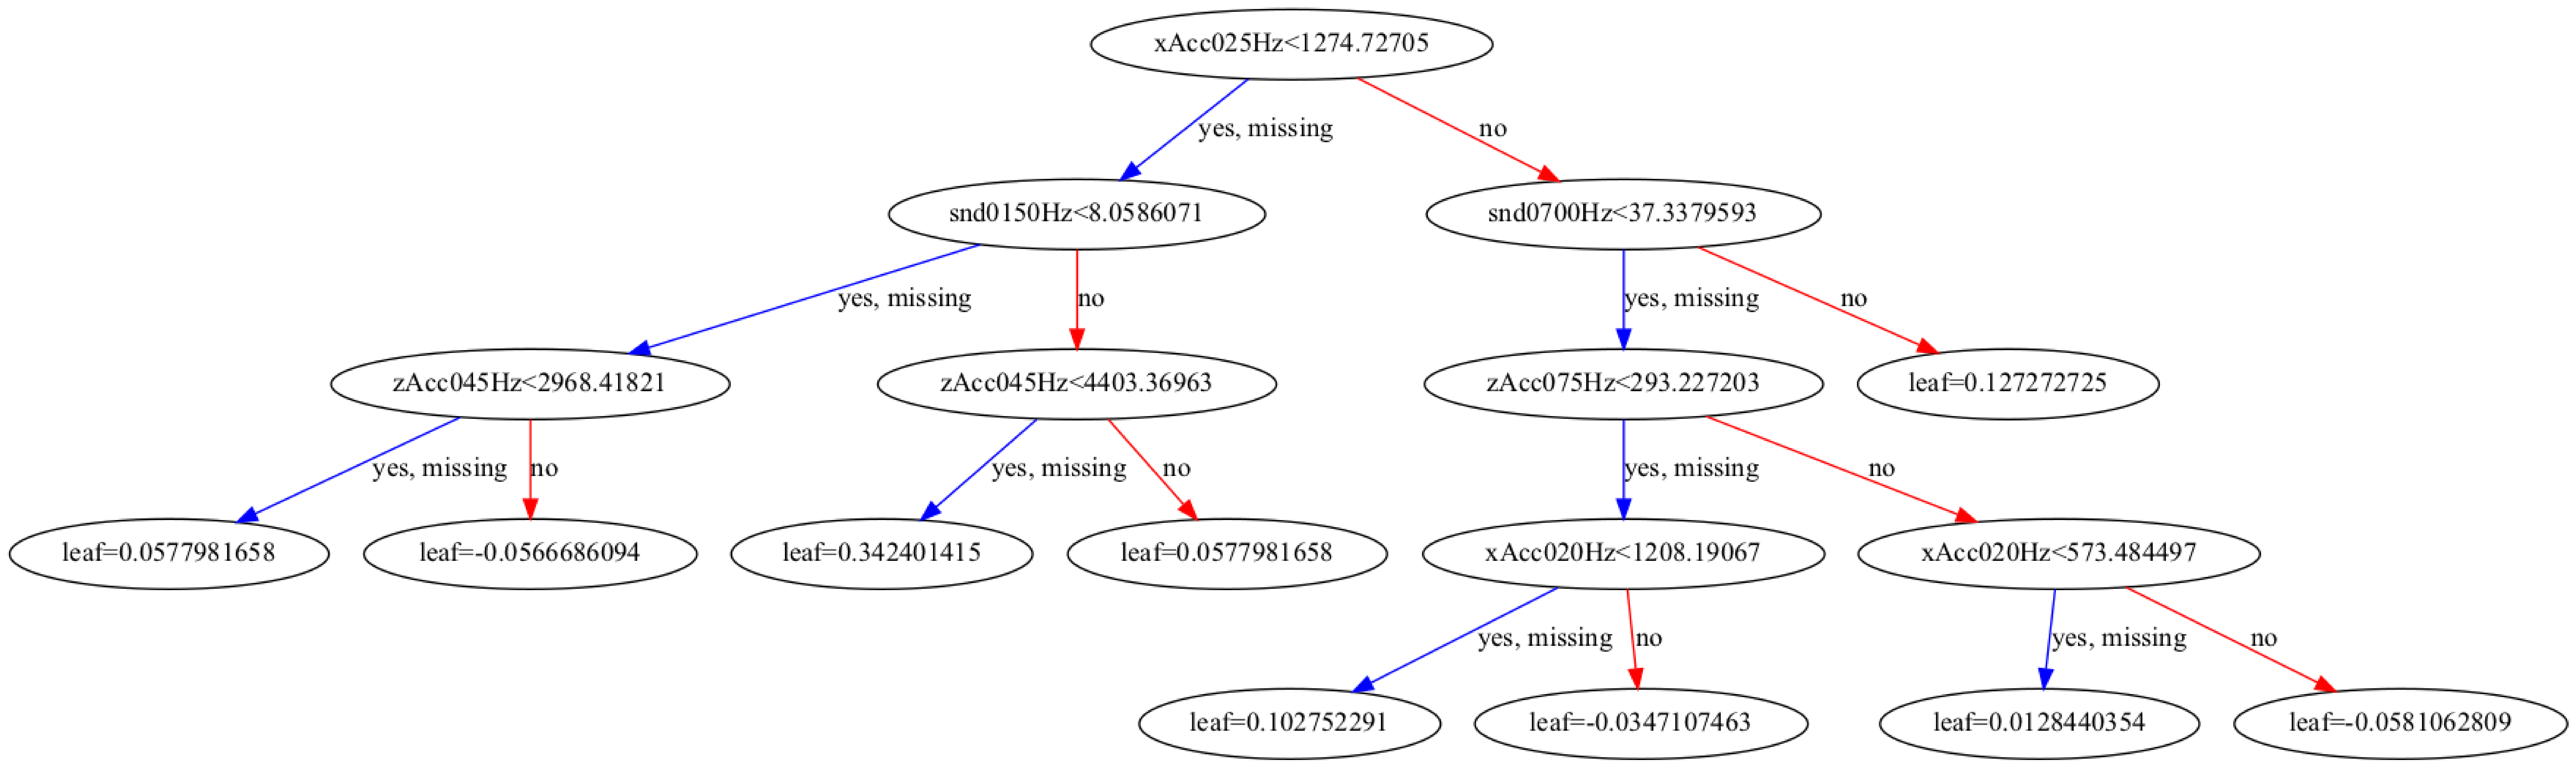

1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt


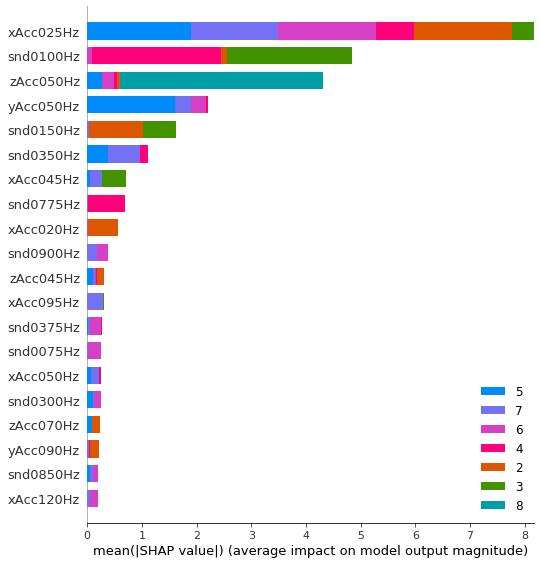

Most important features:
['xAcc025Hz', 'snd0100Hz', 'zAcc050Hz', 'yAcc050Hz', 'snd0150Hz', 'snd0350Hz', 'xAcc045Hz', 'snd0775Hz', 'xAcc020Hz', 'snd0900Hz']


In [3]:
model = xgboost.XGBClassifier(silent = 0,
                              max_depth = 6)
model.fit(x_train, y_train)

# Plot Acc
print("Acc: ", calculate_acc(model.predict(x_test), np_y_test))

# Plot the tree
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(200, 200)
plt.show()

#SHAP
shap_values = shap.TreeExplainer(model).shap_values(x)
print("1:Off; 2:On; 3-Cap; 4:Out; 5: Unb; 6: c25; 7: c75; 8: vnt")
shap.summary_plot(shap_values, x, class_names=model.classes_)

tree_shap = get_all_shap(shap_values, 10, silent=False)



## Analyse

In [4]:
import statistics

def mean_over_col(pre_array):
    """Get the mean of every column of an array

    Parameters
    ----------
    pre_array : numpy.array
        Tim

    """
    # Check the shape of the given array
    num_rows, num_cols = pre_array.shape
    
    # Create a new empty array with the shape
    fin_array = np.empty([num_cols])
    
    for index in range(num_cols):
        fin_array[index] = statistics.mean(pre_array[:,index])
        
    
    return fin_array

    
# 2 = On
shap_values_2 = shap_values[0]
shap_values_2 = mean_over_col(shap_values_2)

# 3 = Cap
shap_values_3 = shap_values[1]
shap_values_3 = mean_over_col(shap_values_3)

# 4 = Out
shap_values_4 = shap_values[2]
shap_values_4 = mean_over_col(shap_values_4)

# 5 = Unb
shap_values_5 = shap_values[3]
shap_values_5 = mean_over_col(shap_values_5)

# 6 = c25
shap_values_6 = shap_values[4]
shap_values_6 = mean_over_col(shap_values_6)

# 7 = c75
shap_values_7 = shap_values[5]
shap_values_7 = mean_over_col(shap_values_7)

# 8 = vnt
shap_values_8 = shap_values[6]
shap_values_8 = mean_over_col(shap_values_8)

# Check the shape
shap_values_2.shape

(169,)

Let's analyse the distribution of the shap_values of those features:
Feature: ID
xAcc025Hz: 0 to 22(120Hz, maximum)
snd0100Hz: 
zAcc050Hz:
yAcc050Hz: 23 to 44
snd0150Hz

Plot:
xAcc: 10Hz to 120Hz, ID = 0 to 22
yAcc: 10Hz to 120Hz, 23 to 45
zAcc: 10Hz to 120Hz, 46 to 69
snd: 70 to 100

In [5]:
#on
shap_values_2

array([ 0.00000000e+00,  0.00000000e+00, -2.50337481e-01, -6.35286152e-01,
       -4.02457190e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.24494964e-03,  0.00000000e+00, -5.62450092e-04,
       -7.37796202e-02, -4.55336012e-02, -1.32999581e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.78390837e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.26520440e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.17879370e-04,  0.00000000e+00,
        0.00000000e+00, -5.03610412e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.77013808e-05,  0.00000000e+00, -7.89939985e-02,
       -2.49618388e-05,  0.00000000e+00,  1.01417405e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.21018393e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [6]:
#cap
shap_values_3

array([ 0.00000000e+00,  0.00000000e+00, -1.10264681e-02, -3.38023096e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.13391635e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.28783355e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.47231608e-03, -1.72613701e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  8.92724129e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [7]:
#out
shap_values_4

array([-6.00902531e-05, -3.47320922e-02,  0.00000000e+00, -3.60382289e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.90219022e-02, -1.56992360e-03,  0.00000000e+00, -5.41314657e-04,
       -5.70553180e-04, -2.25261017e-03,  0.00000000e+00, -9.48829256e-05,
        0.00000000e+00, -2.36171903e-03,  0.00000000e+00, -2.80620094e-04,
        0.00000000e+00, -8.29800410e-05, -8.93867400e-05,  0.00000000e+00,
        0.00000000e+00,  6.11638534e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.90376464e-06,  0.00000000e+00, -2.82573160e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.60810852e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.86674931e-05,
       -6.76559794e-05,  0.00000000e+00,  0.00000000e+00, -1.13859198e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.84417077e-04, -

In [8]:
#unb
shap_values_5

array([-4.66110563e-04, -6.67016313e-04, -1.77264353e-03, -1.10908949e+00,
       -8.04242771e-03,  0.00000000e+00,  7.42296761e-05, -4.93038259e-03,
       -3.34542952e-02,  0.00000000e+00,  1.73483262e-04,  2.30354326e-05,
       -7.57842790e-03, -2.17236150e-02,  6.94620394e-05, -6.53056777e-05,
        1.86479709e-04,  2.20474118e-04,  6.88426517e-05, -1.23070276e-04,
       -1.51975593e-02,  0.00000000e+00, -3.62964836e-03, -7.89673577e-05,
       -3.16575402e-04, -6.79197183e-05,  0.00000000e+00, -8.71870216e-05,
       -5.92435058e-03,  2.21703449e-04,  0.00000000e+00, -6.54427230e-01,
        9.34599575e-06,  2.19460984e-04,  0.00000000e+00, -1.08695868e-03,
        0.00000000e+00, -1.02168834e-03,  0.00000000e+00, -2.57472764e-03,
        0.00000000e+00,  2.24402361e-03,  0.00000000e+00,  0.00000000e+00,
        1.66891870e-04,  3.14290010e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.07740860e-03, -7.21917546e-04, -2.66082527e-04,
       -9.58410965e-05, -

In [9]:
#c25
shap_values_6

array([-3.65763262e-04, -6.08268456e-05, -4.71665151e-03, -1.04915202e+00,
       -1.22669764e-04, -2.69609015e-03,  8.15675157e-05,  1.67862454e-03,
        2.24008909e-04,  0.00000000e+00, -2.32859646e-04,  0.00000000e+00,
        1.04412239e-03, -1.67714804e-02, -1.11357390e-03, -1.66872749e-03,
        2.74980091e-04,  0.00000000e+00, -9.55532363e-04, -9.78854223e-05,
       -5.84287057e-03, -3.13780596e-03, -1.02508664e-01, -1.02769467e-03,
       -3.23863438e-04,  0.00000000e+00, -6.67951943e-04, -2.42483526e-04,
       -1.24869877e-02,  0.00000000e+00, -1.79598574e-03, -1.24193139e-01,
       -8.67206036e-05, -1.67620694e-03, -4.05049912e-04, -1.19088439e-03,
        0.00000000e+00, -1.17491779e-03, -3.08128598e-04, -4.48796153e-03,
        0.00000000e+00, -8.88800016e-04, -9.33623756e-04, -6.07811380e-04,
       -4.10026405e-03, -3.59998521e-04, -3.09946954e-05, -2.15640548e-03,
       -7.41263502e-04, -1.48738548e-03, -3.40380735e-04, -4.06768499e-03,
       -7.36498390e-04, -

In [10]:
#c75
shap_values_7

array([-7.85347365e-05, -2.92200665e-03,  0.00000000e+00, -8.30673277e-01,
        8.10227357e-04, -9.98769538e-05, -6.50819566e-04, -9.32622552e-02,
       -5.97328432e-02,  0.00000000e+00,  5.26357235e-06, -2.27311786e-04,
        1.18406466e-03, -8.63915216e-03, -4.85581295e-05, -3.53871146e-04,
       -4.74096276e-03, -1.50420278e-01, -3.25151510e-03, -3.22645152e-04,
       -3.18423525e-04,  5.95579855e-04,  1.66169740e-02, -3.54106334e-04,
       -2.94122915e-03, -1.61895834e-04, -1.77954398e-02, -1.96975619e-02,
       -5.23246219e-03, -1.80454357e-04, -1.66463610e-02, -1.30332053e-01,
        1.10596215e-04, -8.42057576e-04, -3.88477347e-04, -8.37388565e-04,
       -2.49005661e-05, -2.77099200e-03, -9.28555964e-05,  8.67831986e-04,
        8.11339880e-04, -3.63112740e-05, -1.12031201e-04, -1.51913520e-03,
       -6.38680009e-04, -8.31453130e-04, -6.43651001e-04,  0.00000000e+00,
       -1.71810412e-03, -1.26645891e-02,  0.00000000e+00, -9.75685078e-04,
       -2.35622720e-04, -

In [11]:
#vnt
shap_values_8

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.15297151,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## Plot

In [12]:
# Get the features names
feature_names = df.columns

# Delete "ID"
feature_names = feature_names.drop(['ID'])
feature_names

Index(['xAcc010Hz', 'xAcc015Hz', 'xAcc020Hz', 'xAcc025Hz', 'xAcc030Hz',
       'xAcc035Hz', 'xAcc040Hz', 'xAcc045Hz', 'xAcc050Hz', 'xAcc055Hz',
       ...
       'snd2275Hz', 'snd2300Hz', 'snd2325Hz', 'snd2350Hz', 'snd2375Hz',
       'snd2400Hz', 'snd2425Hz', 'snd2450Hz', 'snd2475Hz', 'snd2500Hz'],
      dtype='object', length=169)

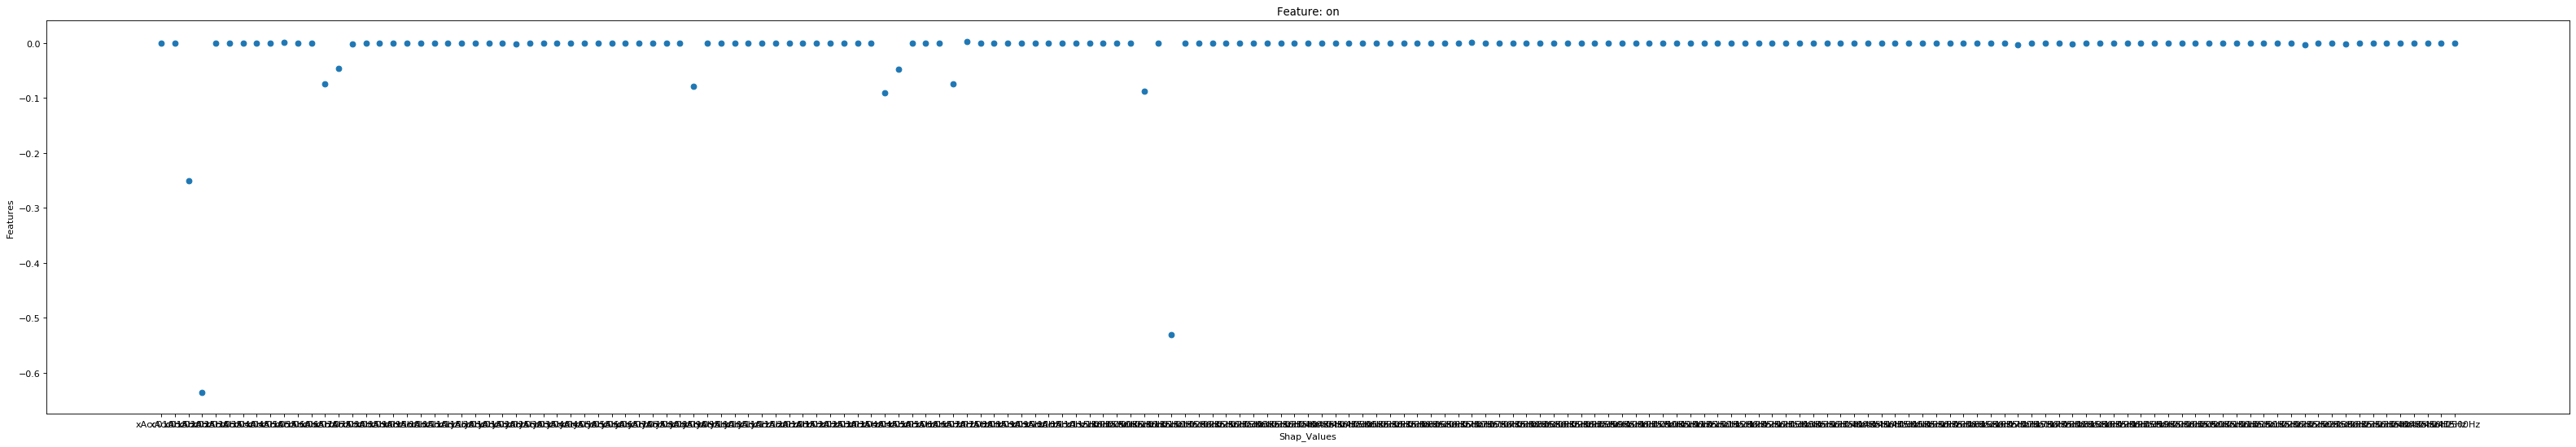

In [13]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_2)
plt.title("Feature: on")
plt.xlabel("Shap_Values")
plt.ylabel("Features")

plt.show()

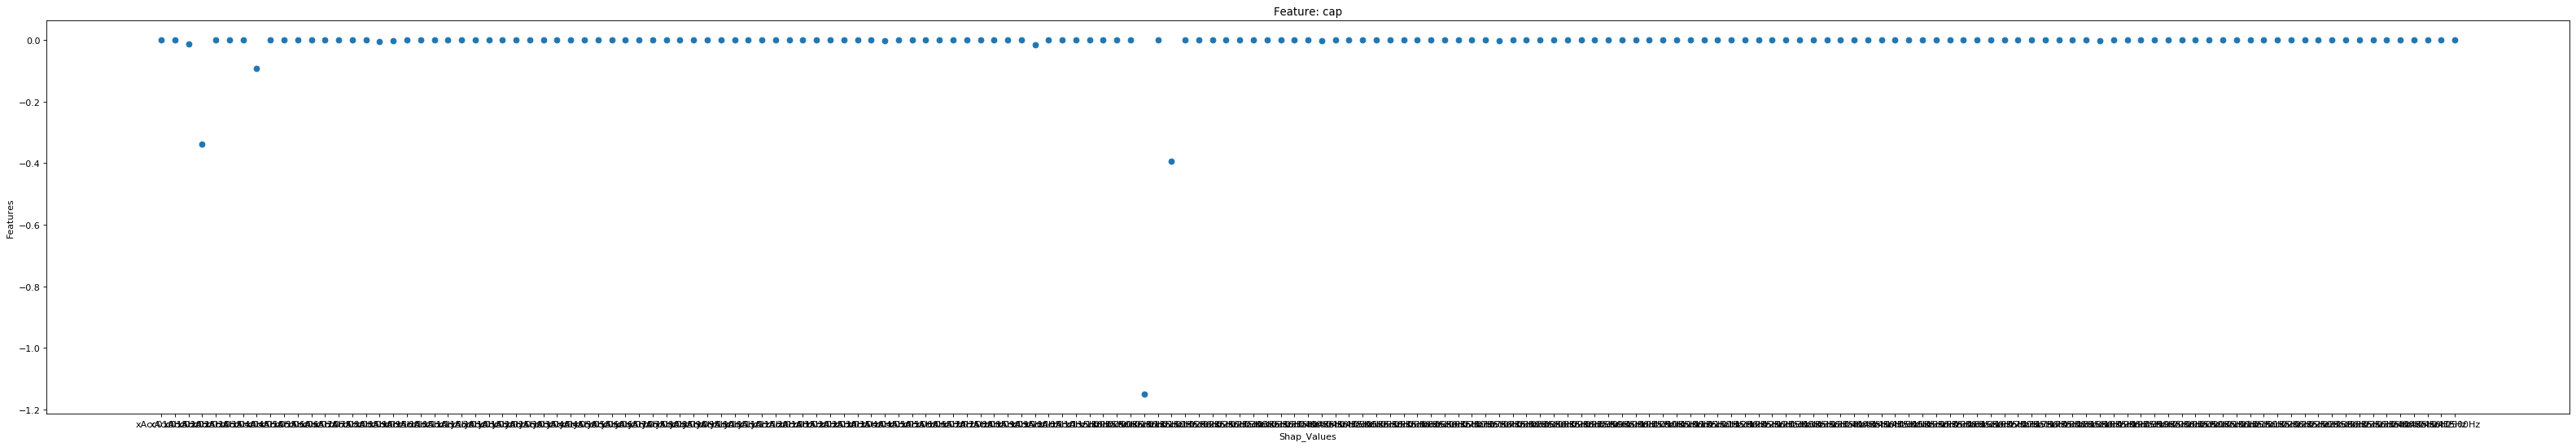

In [14]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_3)
plt.title("Feature: cap")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

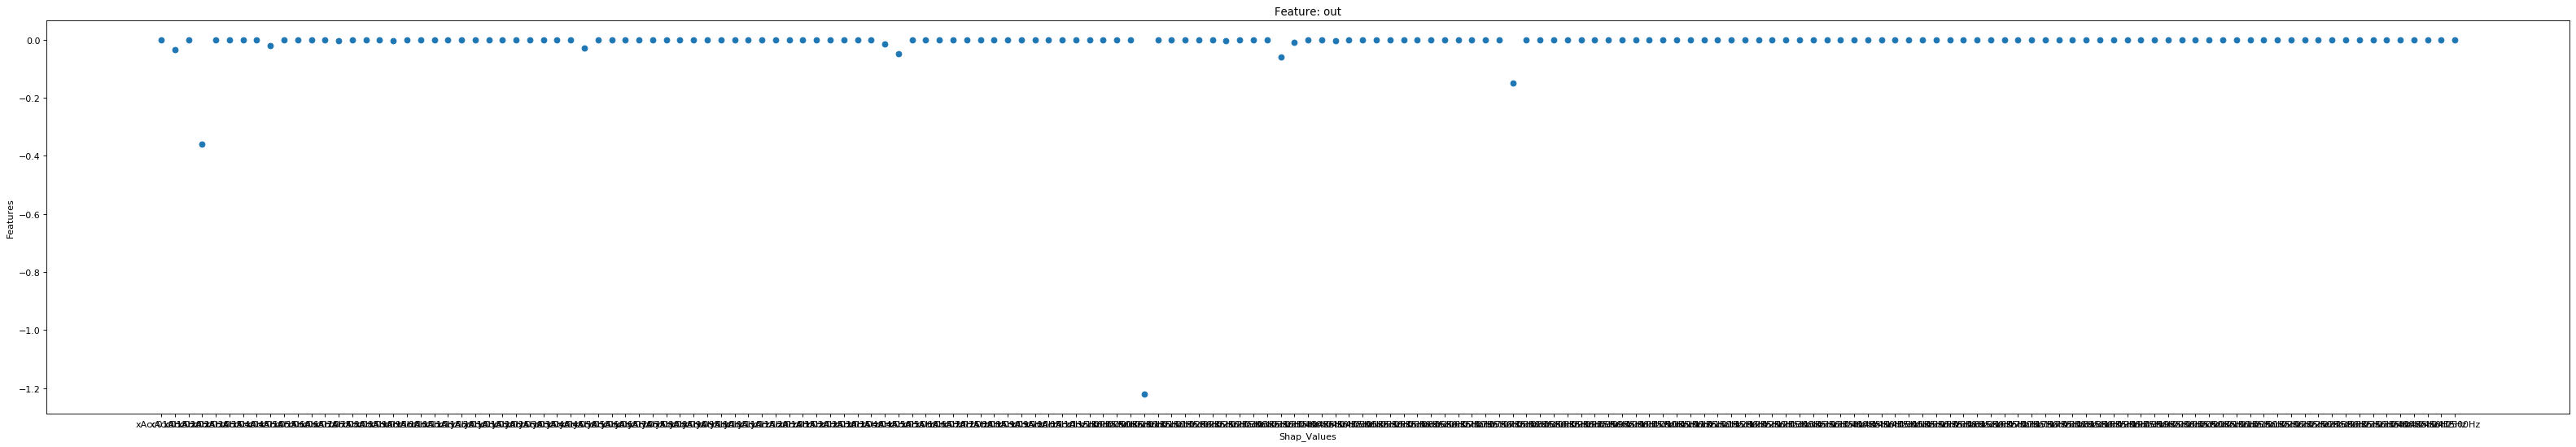

In [15]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_4)
plt.title("Feature: out")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

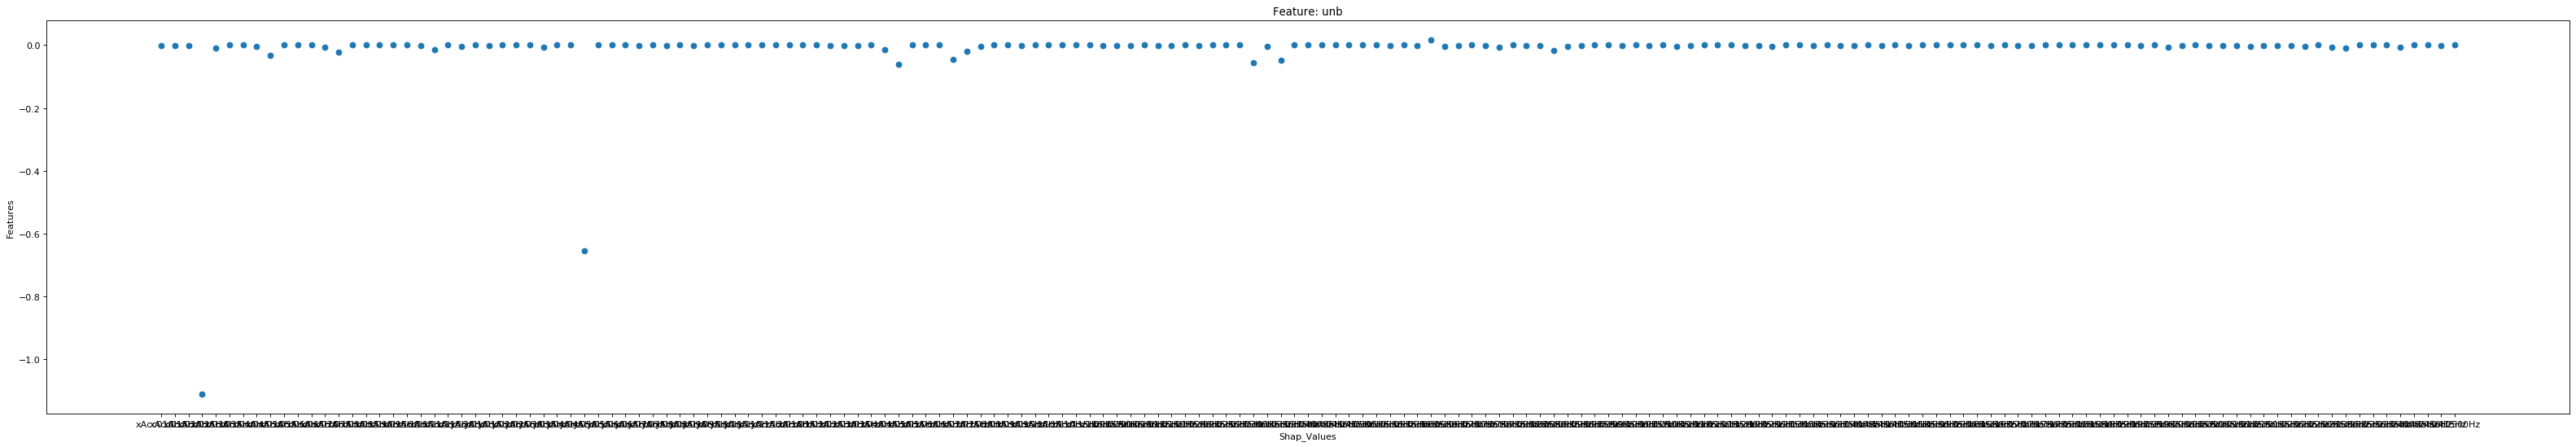

In [16]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_5)
plt.title("Feature: unb")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

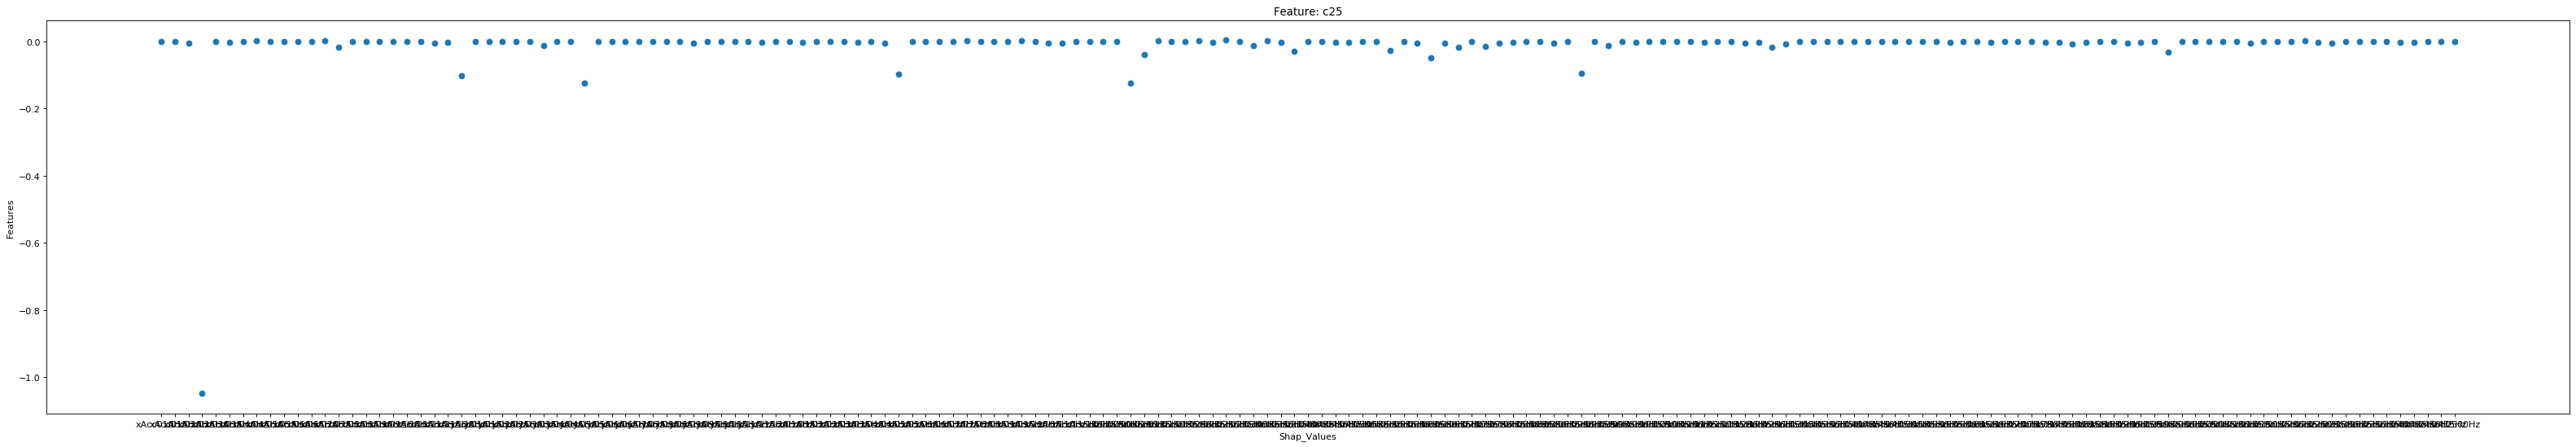

In [17]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_6)
plt.title("Feature: c25")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

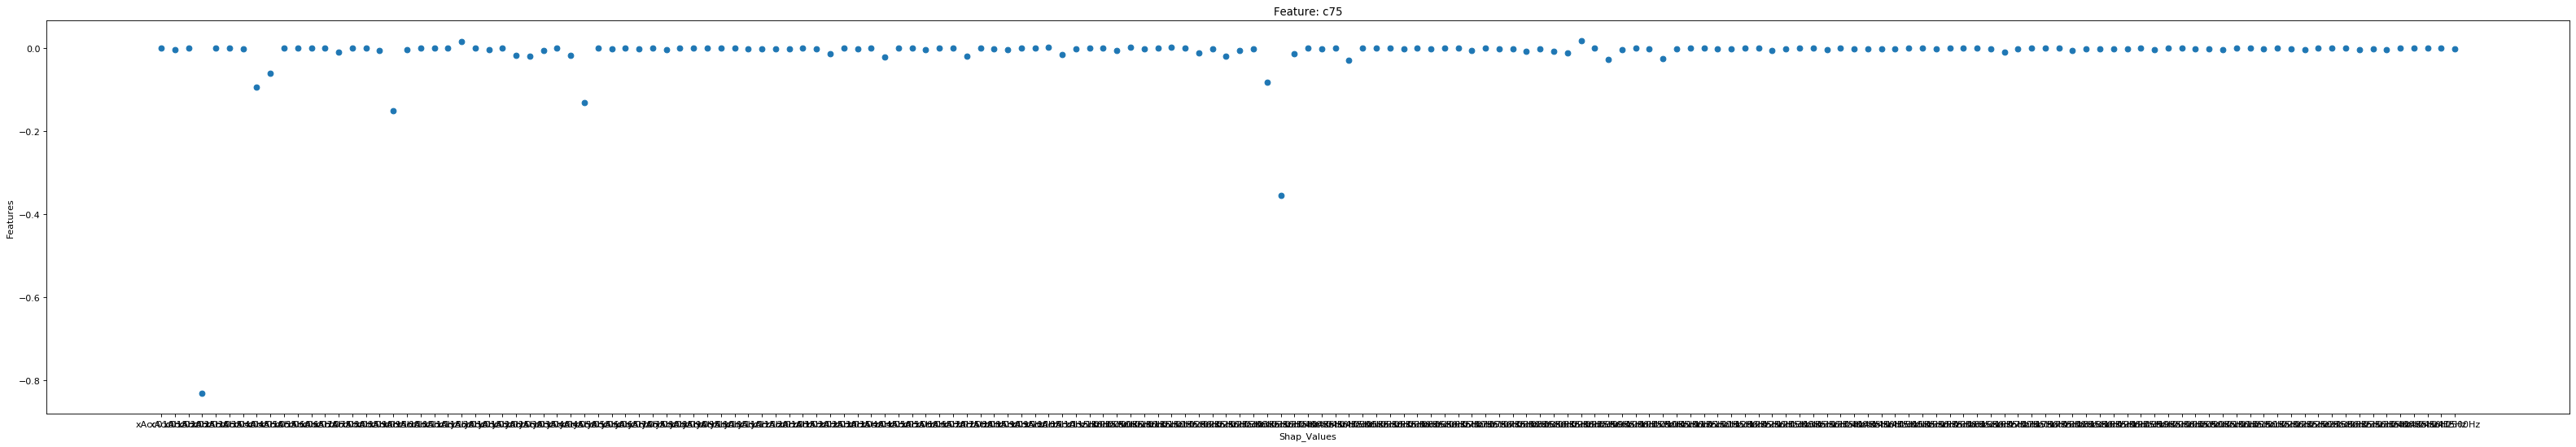

In [18]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_7)
plt.title("Feature: c75")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

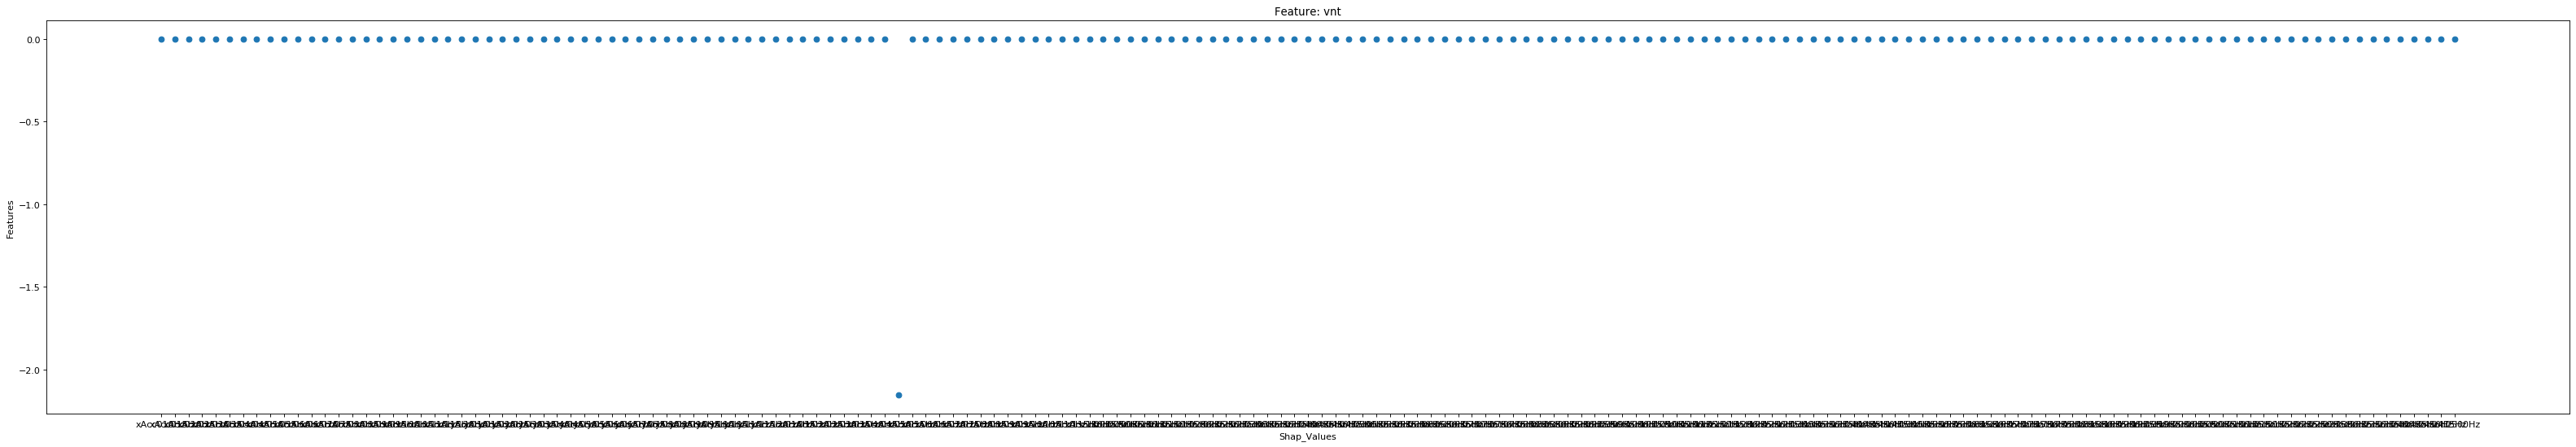

In [19]:
plt.figure(figsize=(50, 8), dpi=80)
plt.scatter(feature_names, shap_values_8)
plt.title("Feature: vnt")
plt.xlabel("Shap_Values")
plt.ylabel("Features")
plt.show()

#### Get the most important features (|shap_value| > 0,2) per label 
With the absolute of all the values the information about in which way the feature impact the prediction goes lost. But that information is not necessary.

In [20]:
# First absolute all shap_values
shap_values_2 = np.absolute(shap_values_2)
shap_values_3 = np.absolute(shap_values_3)
shap_values_4 = np.absolute(shap_values_4)
shap_values_5 = np.absolute(shap_values_5)
shap_values_6 = np.absolute(shap_values_6)
shap_values_7 = np.absolute(shap_values_7)
shap_values_8 = np.absolute(shap_values_8)


In [21]:
def get_imp_features_per_label(shap_values, labels, limit):
    output = []
    
    for feature in range(0,len(shap_values)):
        if shap_values[feature] > limit:
            output.append(labels[feature])
            
    return output

imp_2 = get_imp_features_per_label(shap_values_2, feature_names, 0.2)
print("Label 2: on", imp_2)

imp_3 = get_imp_features_per_label(shap_values_3, feature_names, 0.2)
print("Label 3: cap", imp_3)

imp_4 = get_imp_features_per_label(shap_values_4, feature_names, 0.2)
print("Label 4: out", imp_4)

imp_5 = get_imp_features_per_label(shap_values_5, feature_names, 0.2)
print("Label 5: unb", imp_5)

imp_6 = get_imp_features_per_label(shap_values_6, feature_names, 0.2)
print("Label 6: c25", imp_6)

imp_7 = get_imp_features_per_label(shap_values_7, feature_names, 0.2)
print("Label 7: c75", imp_7)

imp_8 = get_imp_features_per_label(shap_values_8, feature_names, 0.2)
print("Label 8: vnt", imp_8)

Label 2: on ['xAcc020Hz', 'xAcc025Hz', 'snd0150Hz']
Label 3: cap ['xAcc025Hz', 'snd0100Hz', 'snd0150Hz']
Label 4: out ['xAcc025Hz', 'snd0100Hz']
Label 5: unb ['xAcc025Hz', 'yAcc050Hz']
Label 6: c25 ['xAcc025Hz']
Label 7: c75 ['xAcc025Hz', 'snd0350Hz']
Label 8: vnt ['zAcc050Hz']


## Result

All in all we can not see a distribution of the shap values, but with some code we see that predictions of labels like 6 or 8 depends high on only one feature. The next step is too find the distribution of the importance around these features